In [1]:
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
model = keras.models.load_model("./MODEL_V3.h5")

In [3]:
img_height = 331
img_width = 331

In [4]:
class_names = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Domestic Short-Haired', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']

In [5]:
model.layers[0].summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 165, 165, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 165, 165, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

batch_normalization_186 (BatchN (None, 9, 9, 256)    768         conv2d_186[0][0]                 
__________________________________________________________________________________________________
activation_183 (Activation)     (None, 9, 9, 192)    0           batch_normalization_183[0][0]    
__________________________________________________________________________________________________
activation_186 (Activation)     (None, 9, 9, 256)    0           batch_normalization_186[0][0]    
__________________________________________________________________________________________________
block8_6_mixed (Concatenate)    (None, 9, 9, 448)    0           activation_183[0][0]             
                                                                 activation_186[0][0]             
__________________________________________________________________________________________________
block8_6_conv (Conv2D)          (None, 9, 9, 2080)   933920      block8_6_mixed[0][0]             
__________

In [6]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [193]:
from urllib.parse import urlparse
import pathlib
import requests
import shutil
cat = "https://lh3.googleusercontent.com/proxy/2eBVRl_9C8f54VFO3EP_pcR-GBOYZ5ZXtI_90ZeS6SasfjSI-TFi4TZEQ1Rxq9pQ83QtskYdzAjHTJeKKnXkArwT6qhVBqe5Eo_m2vTb3w24SJjHGgfueSTahQ"
headers = {'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
          'accept-encoding': 'gzip, deflate, br',
          'accept-language': 'en-US,en;q=0.9',
          'cache-control': 'max-age=0',
          'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 OPR/73.0.3856.438'}
r = requests.Session().get(cat, stream=True, headers=headers)

a = urlparse(cat)
file_name = os.path.basename(a.path)
if r.status_code == 200:
  with open('./datasets/'+file_name, 'wb') as f:
      r.raw.decode_content = True
      shutil.copyfileobj(r.raw, f)

cat_path = tf.keras.utils.get_file(f'./{file_name}', origin=cat, cache_dir='./')
img = keras.preprocessing.image.load_img(
  cat_path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = preprocess_input(img_array)



In [194]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)], 1000 * (np.max(score)), "%")

Sphynx 183.1068992614746 %


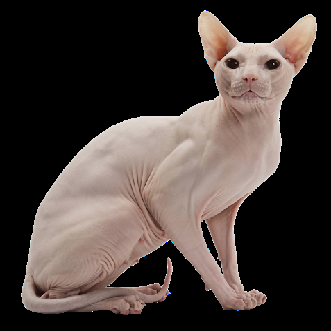

In [195]:
img

In [196]:
from keras import models

inceptionv2 = model.layers[0]

layer_outputs = [layer.output for layer in inceptionv2.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=inceptionv2.input, outputs=layer_outputs)
inceptionv2 = models.Model(inceptionv2.input,inceptionv2.layers[-2].output)
activations = activation_model.predict(img_array, steps=1)

<ipython-input-197-8ae2d09fdd2a>:41: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='binary')


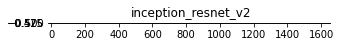

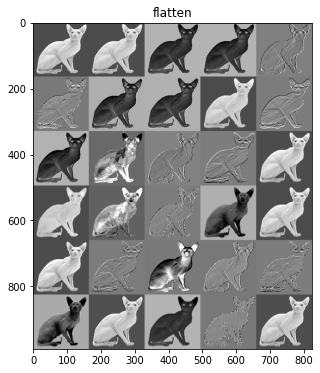

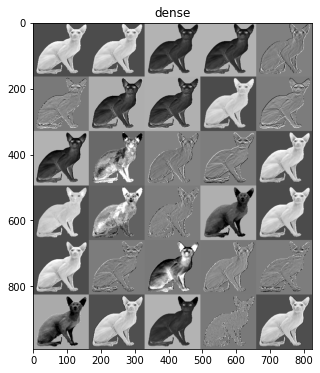

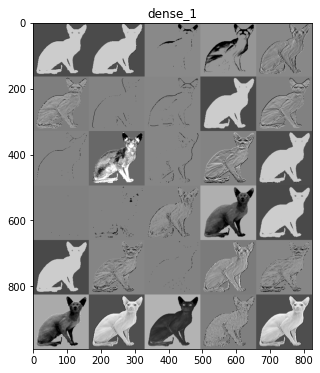

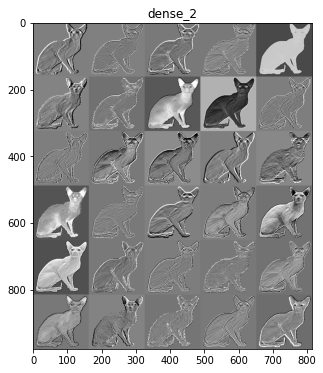

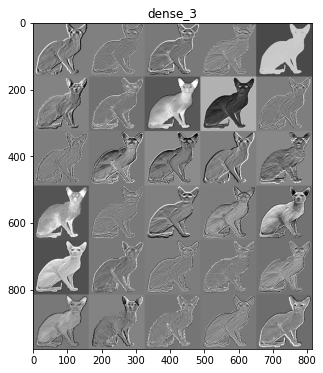

In [197]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

images_per_row = 5

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='binary')
    
plt.show()

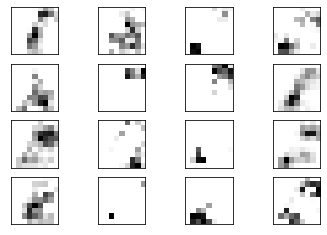

<Figure size 72000x72000 with 0 Axes>

In [178]:
# get feature map for first hidden layer
feature_maps = model.layers[0].predict(img_array, steps=1)
# plot all 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='binary')
        ix += 1
# show the figure
plt.figure(figsize=(1000,1000))
plt.show()

In [77]:
feature_maps

array([[[[-0.35173252, -0.22826086, -0.37254253, ..., -0.41583565,
          -0.28322396, -0.22105041],
         [-0.11417712, -0.23184289, -0.3269536 , ..., -0.3017489 ,
          -0.14353761, -0.21813414],
         [-0.13785505, -0.2710051 , -0.2069216 , ..., -0.28223863,
          -0.15205549, -0.15767583],
         ...,
         [-0.09720384, -0.29082164, -0.08132905, ..., -0.38877067,
          -0.277147  , -0.02868301],
         [-0.19269282, -0.14466205, -0.16792479, ..., -0.18005931,
          -0.25924125, -0.20059517],
         [-0.17588912, -0.17392978, -0.21372288, ..., -0.19859423,
          -0.25272527, -0.17759103]],

        [[-0.5612906 , -0.25872558, -0.25765705, ..., -0.29749677,
          -0.49729225, -0.28527105],
         [-0.21529527, -0.28817722, -0.41235194, ..., -0.2998283 ,
          -0.44935137, -0.16687861],
         [ 0.8215937 , -0.93877244, -1.3448231 , ...,  0.21663854,
           0.06150626,  0.4401834 ],
         ...,
         [-0.1762678 , -0.13609202

In [ ]:
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout

In [ ]:
def deprocess_image(x):
    
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')

    return x

In [ ]:
def generate_pattern(complete_model, layer_name, filter_index, size=150):
    
    layer_output = complete_model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, complete_model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([complete_model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(80):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
activations = model.layers[0].predict(img_array, steps=1)

In [ ]:
fig = plt.figure(figsize=(15, 12))
'''for img in range(5):
    ax = fig.add_subplot(5, 6, img+1)
    ax = plt.imshow(generate_pattern(model.layers[0], 'conv_7b', img))
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)'''

In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)], 1000 * (np.max(score)), "%")